In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta
from keras import layers

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
# Model configuration
img_width, img_height = 32, 32
batch_size = 32
no_epochs = 100
validation_split = 0.04
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.25
number_of_visualizations = 10

In [6]:

x_train = x_train.reshape(x_train.shape[0],  img_width, img_height,3)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height,3)


  

In [7]:
x_shape = (3 ,img_width, img_height)

In [8]:
# Parse numbers as floats
input_train = x_train.astype('float32')
input_test = x_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

input_train = np.clip(input_train, 0., 1.)   
input_test = np.clip(input_test, 0., 1.)


In [9]:
noisy_input = np.copy(input_train)
noisy_input_test = np.copy(input_test)

In [10]:
# Add noise
def drawLines(x):
    for i in range(len(x)):
        numLines = np.random.randint(20) + 1
        for l in range(numLines):
            if l % 2 == 0:
                vh = np.random.randint(2)
                start = np.random.randint(10)
                length = start + np.random.randint(4,21)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
            else:
                vh = np.random.randint(2)
                start = np.random.randint(10,25)
                length = start + np.random.randint(5,32-start)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
    return x

In [11]:

noisy_input = drawLines(noisy_input)
noisy_input_test = drawLines(noisy_input_test)

In [12]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

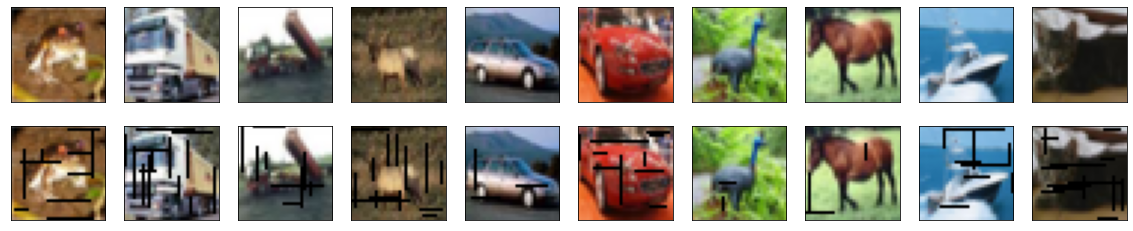

In [13]:
showOrigDec(input_train, noisy_input)


In [17]:

# Create the model
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
encoded = Activation('sigmoid')(x)

x = Dense(3072)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Reshape((32,32,3))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [23]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0   

In [24]:
# Compile and fit data
# model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=1)
model.fit(noisy_input, input_train,
                epochs=no_epochs,
                batch_size=32,
                validation_split=validation_split,
          shuffle=True,
          callbacks=[es])

Train on 48000 samples, validate on 2000 samples
Epoch 1/100
48000/48000 [==============================] - 73s 2ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 2/100
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 3/100
48000/48000 [==============================] - 67s 1ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 4/100
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 5/100
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/100
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 7/100
48000/48000 [==============================] - 67s 1ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 8/100
48000/48000 [==============================] - 67s 1ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/100
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0026 - val_loss: 0.00

In [26]:
score = model.evaluate(input_test, noisy_input_test, verbose=1)
print(score)


10000/10000 [==============================] - 2s 195us/step
0.02999547044634819


In [28]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = input_test[:number_of_visualizations]
denoised_images = model.predict(samples)

In [29]:
def showOrigDec(orig, noise, denoised, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        #display denoise image
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(denoised[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


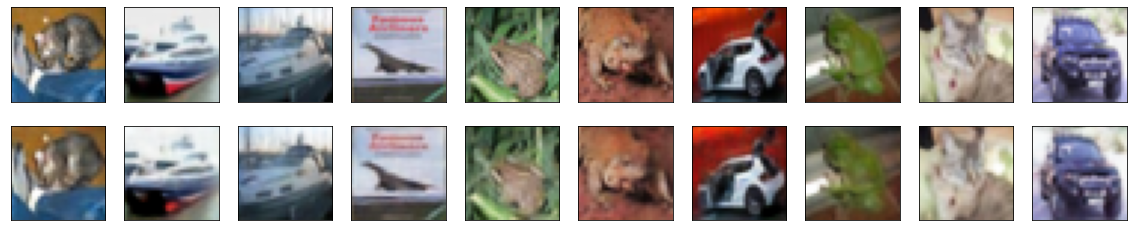

In [30]:
showOrigDec(input_test, samples, denoised_images)


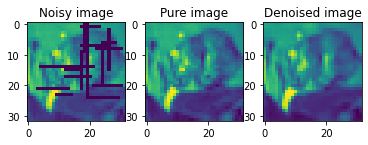

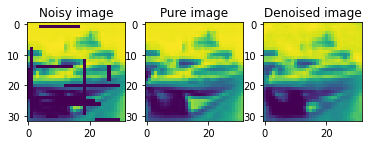

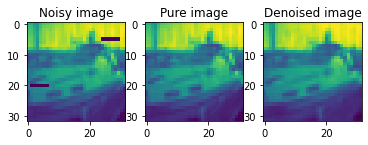

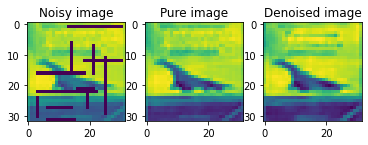

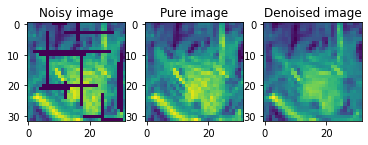

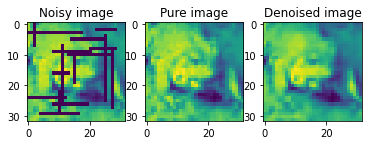

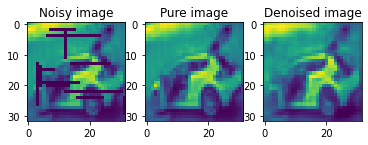

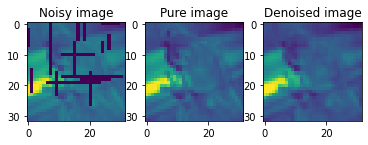

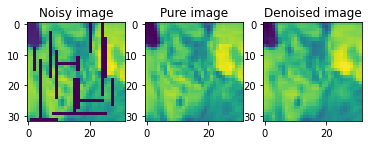

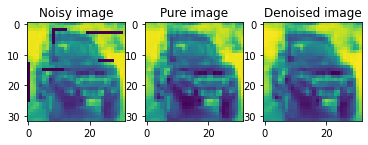

In [31]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = input_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(6, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  
  plt.show()